In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.ndimage.interpolation import shift
import os
import seaborn as sns
import json

from pdftabextract.common import read_xml, parse_pages
from pdftabextract.clustering import zip_clusters_and_values
from pdftabextract.textboxes import border_positions_from_texts, split_texts_by_positions, join_texts
from pdftabextract.common import all_a_in_b, DIRECTION_VERTICAL
from pdftabextract.clustering import find_clusters_1d_break_dist
from pdftabextract.clustering import calc_cluster_centers_1d
from pdftabextract.extract import make_grid_from_positions
from pdftabextract.extract import fit_texts_into_grid, datatable_to_dataframe

from tabula import read_pdf
import pandas as pd

%matplotlib inline

In [2]:
from tables_detector.tables_detector import TableDetector

# Pdf preparation into image file

In [3]:

dat_path = "../../../dat/DATASETS/NL 14614829 - Claim File- image 1_Part 1/Output"
dat_path = "../../../dat"

In [2]:
pdf_file_name = 'Accident-Handwritten_V3.pdf'
#pdf_file_name = 'Deidentified medical record.pdf'
#pdf_file_name = 'EgyptJHaematol_2012_37_4_207_134966_5.pdf'

base_file_name = os.path.splitext(pdf_file_name)[0]
page_num = 1
# Convert pdf to tiff
cmd = 'convert -density 300 ' + pdf_file_name + '[' + str(page_num-1) + ']' + ' ' + base_file_name+'.tiff'
#cmd = 'convert -density 150 ' + pdf_file_name + ' ' + base_file_name+'.tiff'
os.system(cmd)

# Convert tiff to pdf sandwitch
cmd = 'tesseract' + ' ' + base_file_name+'.tiff' + ' ' + base_file_name+'_pdf_sand' + ' pdf'
#cmd = 'tesseract' + ' ' + 'Page 3.tiff' + ' ' + base_file_name+'_pdf_sand' + ' pdf'
os.system(cmd)

# Convert pdf sandwitch to xml
xml_file = base_file_name+'.xml'
cmd = 'pdftohtml -c -hidden -xml' + ' ' + base_file_name+'_pdf_sand.pdf' + ' ' + xml_file
os.system(cmd)

0

In [5]:
#!python3 -m http.server 8080 --bind 127.0.0.1

 http://127.0.0.1:8080/pdf2xml-viewer.html.

# Watershed and distance transform segmentation
https://docs.opencv.org/3.4/d2/dbd/tutorial_distance_transform.html

In [4]:

file_name = base_file_name+'.tiff'


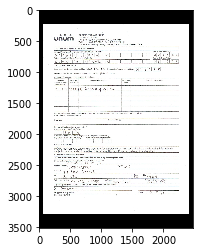

In [11]:
from __future__ import print_function
import cv2 as cv
import numpy as np
import argparse
import random as rng
# Load the image
'''
parser = argparse.ArgumentParser(description='Code for Image Segmentation with Distance Transform and Watershed Algorithm.\
    Sample code showing how to segment overlapping objects using Laplacian filtering, \
    in addition to Watershed and Distance Transformation')
parser.add_argument('--input', help='Path to input image.', default=file_name)
args = parser.parse_args()
'''
src = cv.imread(file_name)
if src is None:
    print('Could not open or find the image:', args.input)
    exit(0)
# Show source image
plt.imshow(src)

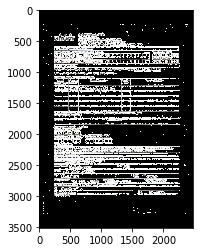

In [12]:
# Change the background from white to black, since that will help later to extract
# better results during the use of Distance Transform
src[np.all(src == 255, axis=2)] = 0
# Show output image
plt.imshow(src)

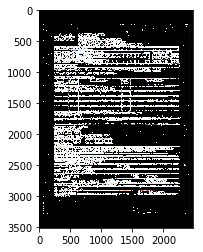

In [15]:
# Create a kernel that we will use to sharpen our image
# an approximation of second derivative, a quite strong kernel
kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
# do the laplacian filtering as it is
# well, we need to convert everything in something more deeper then CV_8U
# because the kernel has some negative values,
# and we can expect in general to have a Laplacian image with negative values
# BUT a 8bits unsigned int (the one we are working with) can contain values from 0 to 255
# so the possible negative number will be truncated
imgLaplacian = cv.filter2D(src, cv.CV_32F, kernel)
sharp = np.float32(src)
imgResult = sharp - imgLaplacian
# convert back to 8bits gray scale
imgResult = np.clip(imgResult, 0, 255)
imgResult = imgResult.astype('uint8')
imgLaplacian = np.clip(imgLaplacian, 0, 255)
imgLaplacian = np.uint8(imgLaplacian)
#plt.imshow(imgLaplacian)
plt.imshow(imgResult)

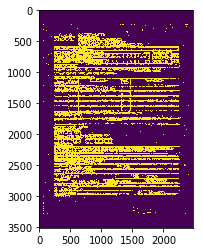

In [16]:
# Create binary image from source image
bw = cv.cvtColor(imgResult, cv.COLOR_BGR2GRAY)
_, bw = cv.threshold(bw, 40, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
plt.imshow(bw)

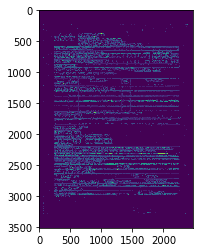

In [17]:
# Perform the distance transform algorithm
dist = cv.distanceTransform(bw, cv.DIST_L2, 3)
# Normalize the distance image for range = {0.0, 1.0}
# so we can visualize and threshold it
cv.normalize(dist, dist, 0, 1.0, cv.NORM_MINMAX)
plt.imshow(dist)

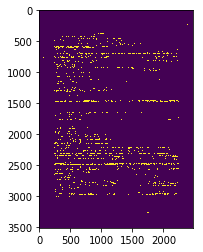

In [18]:
# Threshold to obtain the peaks
# This will be the markers for the foreground objects
_, dist = cv.threshold(dist, 0.4, 1.0, cv.THRESH_BINARY)
# Dilate a bit the dist image
kernel1 = np.ones((3,3), dtype=np.uint8)
dist = cv.dilate(dist, kernel1)
plt.imshow(dist)

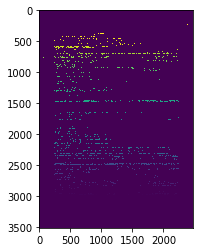

In [19]:
# Create the CV_8U version of the distance image
# It is needed for findContours()
dist_8u = dist.astype('uint8')
# Find total markers
_, contours, _ = cv.findContours(dist_8u, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# Create the marker image for the watershed algorithm
markers = np.zeros(dist.shape, dtype=np.int32)
# Draw the foreground markers
for i in range(len(contours)):
    cv.drawContours(markers, contours, i, (i+1), -1)
# Draw the background marker
cv.circle(markers, (5,5), 3, (255,255,255), -1)
plt.imshow(markers*10000)

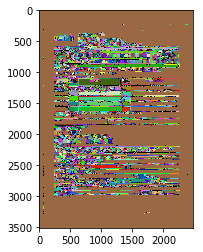

In [20]:
# Perform the watershed algorithm
cv.watershed(imgResult, markers)
#mark = np.zeros(markers.shape, dtype=np.uint8)
mark = markers.astype('uint8')
mark = cv.bitwise_not(mark)
# uncomment this if you want to see how the mark
# image looks like at that point
#cv.imshow('Markers_v2', mark)
# Generate random colors
colors = []
for contour in contours:
    colors.append((rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)))
# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1]
# Visualize the final image
plt.imshow(dst)

/home/ahmad/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


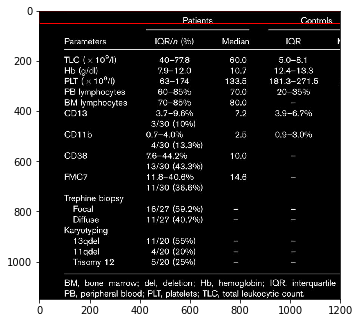

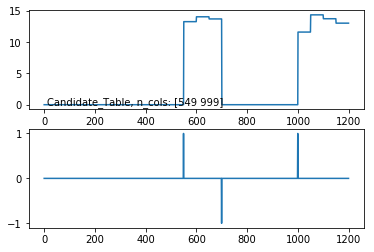

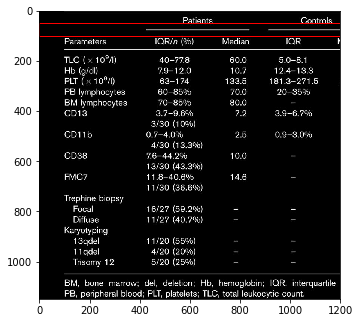

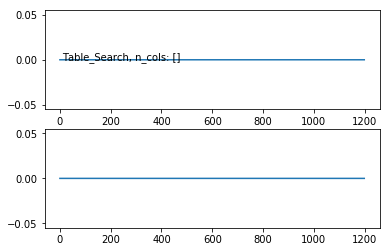

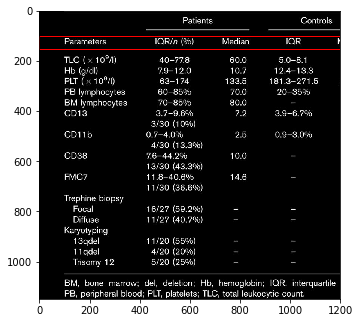

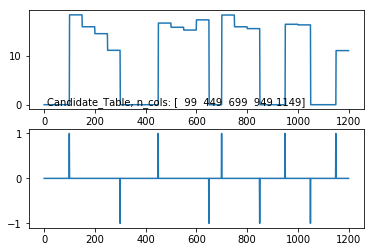

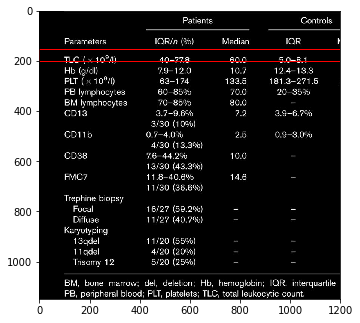

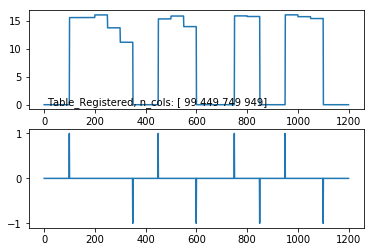

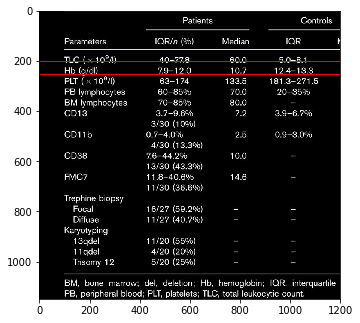

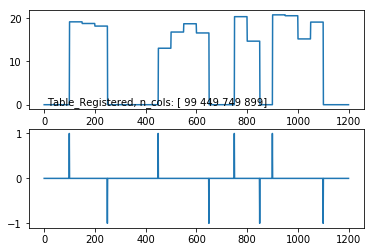

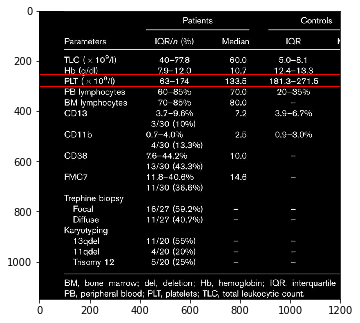

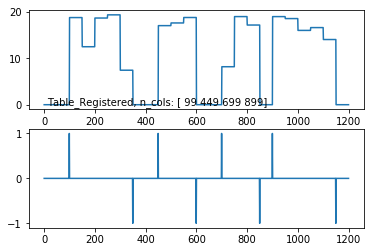

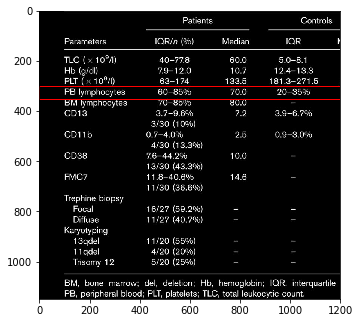

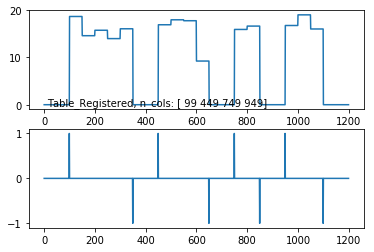

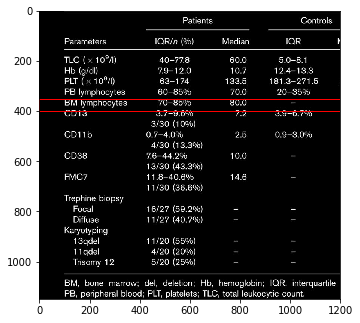

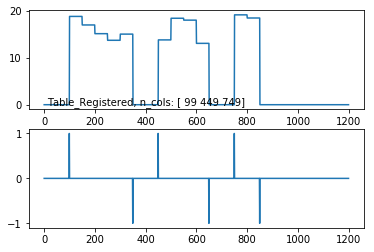

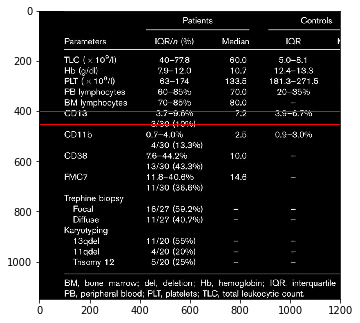

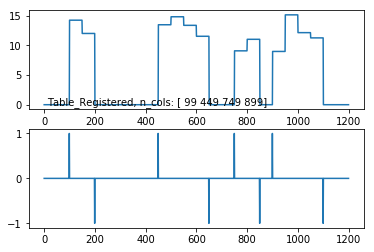

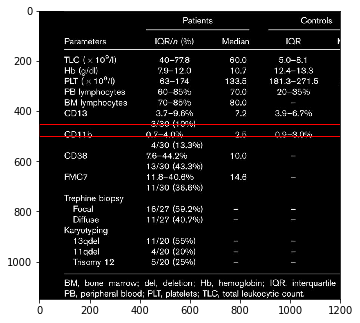

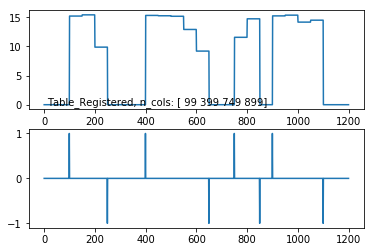

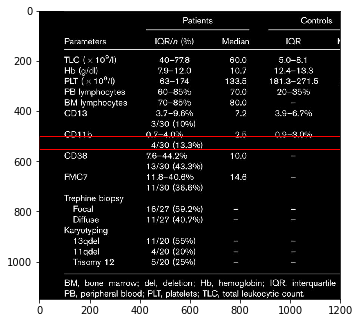

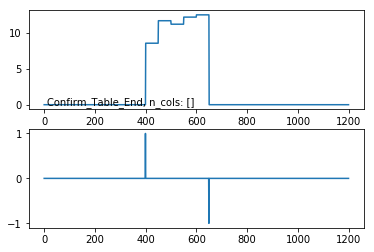

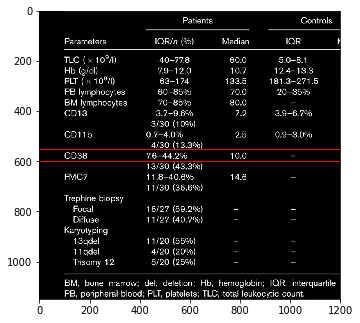

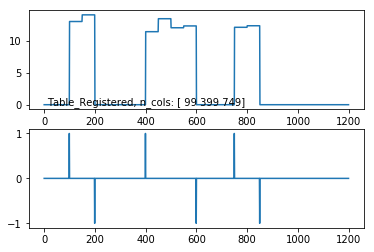

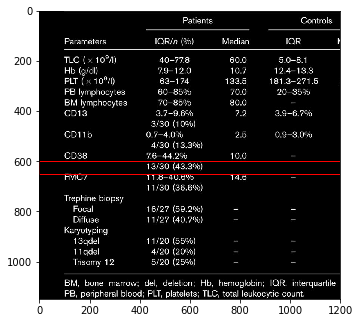

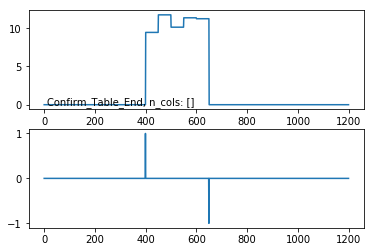

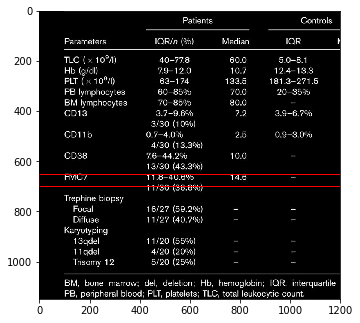

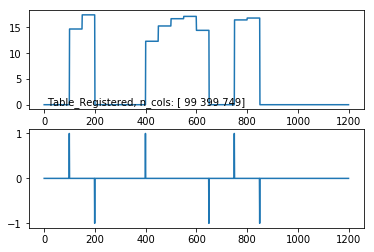

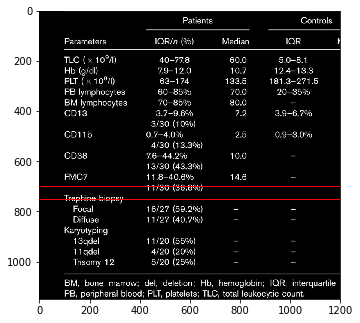

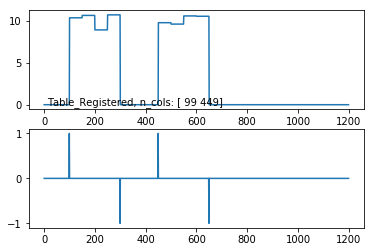

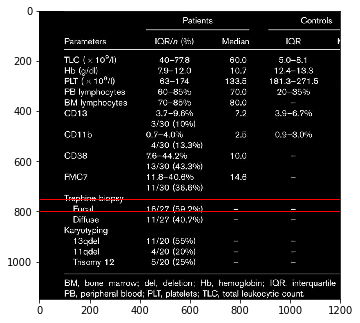

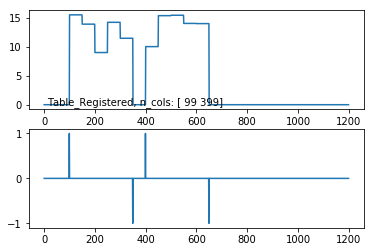

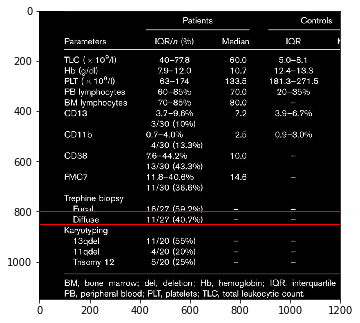

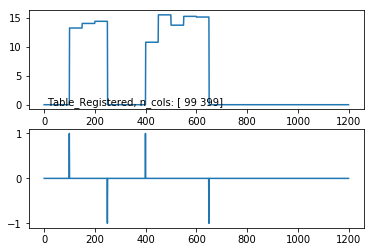

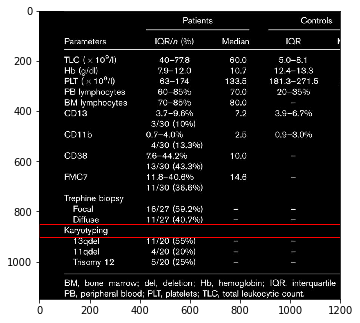

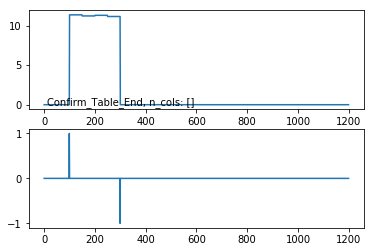

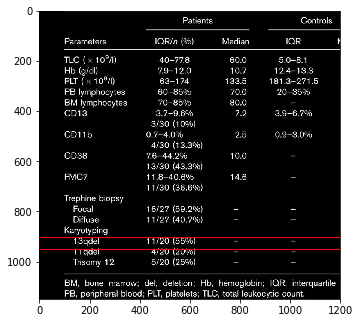

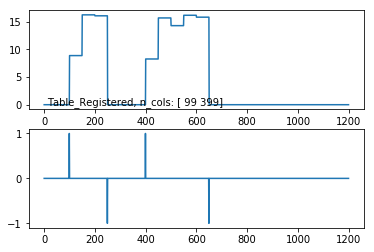

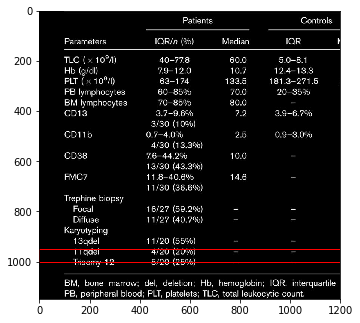

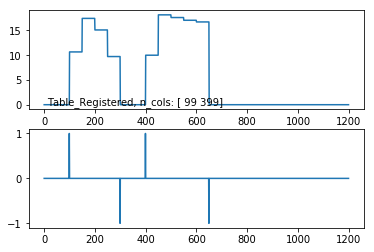

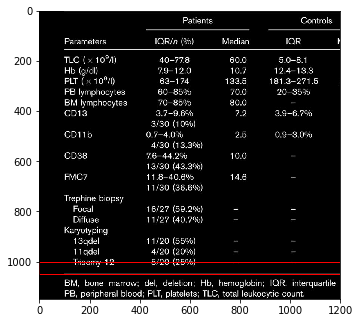

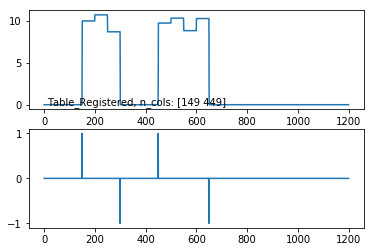

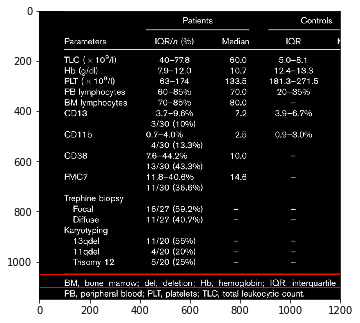

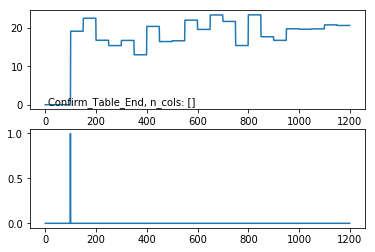

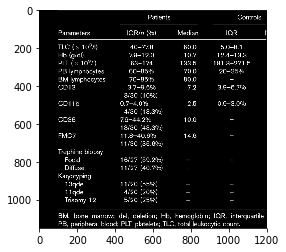

'{"data": []}'

In [20]:
verbose = False
# 3508x2379 ~ 90linesx25words ~ pixels/word = 96, pixels/line=40--> strip_height > 40 (*2 for header usually > 2 lines) (100) w_max_pool < 96 (50)
tables_detector = TableDetector(verbose, strip_height=50, w_max_pool=75, min_col_width=250, ratio_clip_max=0.25)
#tables_detector = TableDetector(verbose, strip_height=50, w_max_pool=50, min_col_width=100, ratio_clip_max=0.25)
tables = tables_detector.detect_tables(img)
tables_detector.visualize_tables(img_orig, file_name)
tables_detector.fit_text_to_tables(xml_file)
#tables_detector.save_json(base_file_name)
list_of_json_tables = tables_detector.get_tables_in_json()
json.dumps({"data": list_of_json_tables})

In [23]:
list_of_json_tables

[{'Unnamed: 0': {'0': None,
   '1': None,
   '2': 'Parameters',
   '3': 'TLC (x 10°/I)',
   '4': 'Hb (g/dl)',
   '5': 'PLT (x 10°!)',
   '6': 'PB lymphocytes',
   '7': 'BM lymphocytes',
   '8': 'CD13',
   '9': None,
   '10': 'CD11b',
   '11': None,
   '12': 'CD38',
   '13': None,
   '14': 'FMC7',
   '15': None,
   '16': 'Trephine biopsy',
   '17': 'Focal',
   '18': 'Diffuse',
   '19': 'Karyotyping',
   '20': '13qdel',
   '21': '11qdel',
   '22': 'Trisomy 12'},
  'Unnamed: 1': {'0': 'Patients',
   '1': None,
   '2': 'IQR/n (%)',
   '3': '40-77.8',
   '4': '7.9-12.0',
   '5': '63-174',
   '6': '60-85%',
   '7': '70-85%',
   '8': '3.7-9.6%',
   '9': '3/30 (10%)',
   '10': '0.7-4.0%',
   '11': '4/30 (13.3%)',
   '12': '7.6-44.2%',
   '13': '13/30 (43.3%)',
   '14': '11.8-40.6%',
   '15': '11/30 (36.6%)',
   '16': None,
   '17': '16/27 (59.2%)',
   '18': '11/27 (40.7%)',
   '19': None,
   '20': '11/20 (55%)',
   '21': '4/20 (20%)',
   '22': '5/20 (25%)'},
  'Unnamed: 2': {'0': None,
   '1':

In [22]:

df_tabula = read_pdf(pdf_file_name)# If tables with lines, better use tabula 

try:
    df_tabula.to_json(base_file_name+'.json')
    list_of_json_tables = [json.loads(df_tabula.to_json())]
    
except:
    verbose = False
    # 3508x2379 ~ 90linesx25words ~ pixels/word = 96, pixels/line=40--> strip_height > 40 (*2 for header usually > 2 lines) (100) w_max_pool < 96 (50)
    tables_detector = TableDetector(verbose, strip_height=50, w_max_pool=75, min_col_width=250, ratio_clip_max=0.25)
    tables = tables_detector.detect_tables(img)
    tables_detector.visualize_tables(img_orig, file_name)
    tables_detector.fit_text_to_tables(xml_file)
    #tables_detector.save_json(base_file_name)
    list_of_json_tables = tables_detector.get_tables_in_json()
    
json.dumps({"data": list_of_json_tables})

'{"data": [{"Unnamed: 0": {"0": null, "1": null, "2": "Parameters", "3": "TLC (x 10\\u00b0/I)", "4": "Hb (g/dl)", "5": "PLT (x 10\\u00b0!)", "6": "PB lymphocytes", "7": "BM lymphocytes", "8": "CD13", "9": null, "10": "CD11b", "11": null, "12": "CD38", "13": null, "14": "FMC7", "15": null, "16": "Trephine biopsy", "17": "Focal", "18": "Diffuse", "19": "Karyotyping", "20": "13qdel", "21": "11qdel", "22": "Trisomy 12"}, "Unnamed: 1": {"0": "Patients", "1": null, "2": "IQR/n (%)", "3": "40-77.8", "4": "7.9-12.0", "5": "63-174", "6": "60-85%", "7": "70-85%", "8": "3.7-9.6%", "9": "3/30 (10%)", "10": "0.7-4.0%", "11": "4/30 (13.3%)", "12": "7.6-44.2%", "13": "13/30 (43.3%)", "14": "11.8-40.6%", "15": "11/30 (36.6%)", "16": null, "17": "16/27 (59.2%)", "18": "11/27 (40.7%)", "19": null, "20": "11/20 (55%)", "21": "4/20 (20%)", "22": "5/20 (25%)"}, "Unnamed: 2": {"0": null, "1": null, "2": "Median", "3": "60.0", "4": "10.7", "5": "133.5", "6": "70.0", "7": "80.0", "8": "7.2", "9": null, "10": 

In [12]:
df_tabula

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Patients,NaN,Controls,NaN
1,NaN,NaN,NaN,NaN,NaN
2,Parameters,IQR/n (%),Median,IQR,Median
3,TLC (x 10°/I),40-77.8,60.0,5.0-8.1,6.5
4,Hb (g/dl),7.9-12.0,10.7,12.4-13.3,12.9
5,PLT (x 10°!),63-174,133.5,181.3-271.5,231.5
6,PB lymphocytes,60-85%,70.0,20-35%,24.0
7,BM lymphocytes,70-85%,80.0,-,=~
8,CD13,3.7-9.6%,7.2,3.9-6.7%,5.2
9,NaN,3/30 (10%),NaN,NaN,NaN


In [13]:
with open(base_file_name+'.json', 'w') as outfile:  
    json.dump({"data": list_of_json_tables}, outfile)